## MODELOS DE LSTM PARA PRONÓSTICO DE DEMANDA DE GAS NATURAL EN SECTOR petrolero EN MÉXICO
## UNAM
## Alumno: Ibarra Ramírez Sergio

Importamos la data de Demanda de gas en sector eléctrico como un CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sympy import true
from datetime import datetime, timedelta
register_matplotlib_converters()
from time import time 

Se lee la data "original" de Demanda en sector petrolero

In [2]:
csv_demanda_petrolero_original = pd.read_csv('Demanda_petrolero_2022_full1.csv',index_col='Date',parse_dates=True)
csv_demanda_petrolero_original

,Demanded_Gas
Date,
2005-01-01,2039.88
2005-02-01,2015.25
2005-03-01,1969.51
2005-04-01,2008.19
2005-05-01,2041.86
...,...
2022-05-01,1919.43
2022-06-01,1876.88
2022-07-01,1979.70


Se grafica la data "original" de Demanda en sector petrolero

Text(0, 0.5, 'Demanda [MMpcd]')

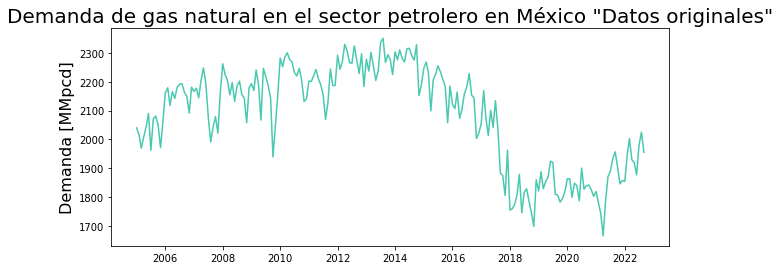

In [4]:
plt.figure(figsize=(10,4))
plt.plot(csv_demanda_petrolero_original, color='#48C9B0')
plt.title('Demanda de gas natural en el sector petrolero en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data "original" de Demanda en sector eléctrico en sus compoentes de Tendencia, Estacionalidad y Residual

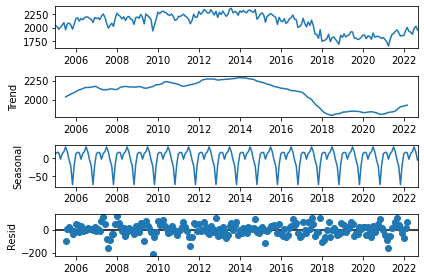

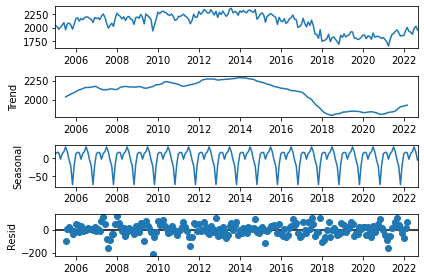

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

csv_demanda_petrolero_original_seasonal_decomposition = seasonal_decompose(csv_demanda_petrolero_original)
csv_demanda_petrolero_original_seasonal_decomposition.plot()

Para la aplicación de RNN(LSTM) combiene escalar la data. Por lo que se requiere definir y entrenar el MinMaxScaler 
Y por ello es necesario separar la data en train y test 

Separamos la data original de Demanda de gas natural en el sector petrolero en data de train y test

In [6]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
demanda_petrolero_original_train_data = csv_demanda_petrolero_original[:-num_test_points]
demanda_petrolero_original_test_data = csv_demanda_petrolero_original[-num_test_points:]

demanda_petrolero_original_train_data

,Demanded_Gas
Date,
2005-01-01,2039.88
2005-02-01,2015.25
2005-03-01,1969.51
2005-04-01,2008.19
2005-05-01,2041.86
...,...
2021-05-01,1785.32
2021-06-01,1870.67
2021-07-01,1889.20


Se define y entrena el MinMaxScaler (con la data de train)

In [7]:
from sklearn.preprocessing import MinMaxScaler
MinMax_scaler = MinMaxScaler()
MinMax_scaler.fit(demanda_petrolero_original_train_data)

MinMaxScaler()

Se aplica la escalación de data a la data de train y test

In [8]:
demanda_petrolero_original_train_scaled = MinMax_scaler.transform(demanda_petrolero_original_train_data)
demanda_petrolero_original_test_scaled = MinMax_scaler.transform(demanda_petrolero_original_test_data)


Se grafica la distribución de los datos "originales escalados" de train de Demanda en sector eléctrico

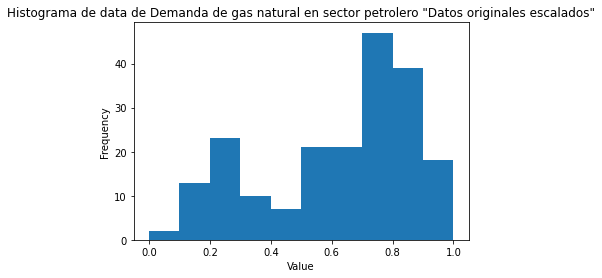

In [9]:
# Generate the histogram
plt.hist(demanda_petrolero_original_train_scaled, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector petrolero "Datos originales escalados"')

# Display the plot
plt.show()

Se lleva a cabo una prueba de normalidad a los datos "originales escalados" de train de Demanda en sector eléctrico

In [10]:
import scipy.stats as stats

# Assuming demanda_electrico_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_petrolero_original_train_scaled

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data NO sigue una distribución normal
Jarque-Bera Statistic: 20.202047251153047
p-value: 4.1037526656295675e-05


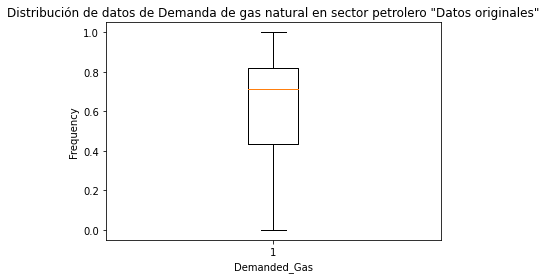

In [11]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_petrolero_original_train_scaled)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector petrolero "Datos originales"')

# Display the plot
plt.show()

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [12]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [13]:
n_input = 24

data = demanda_petrolero_original_train_scaled
targets = data 

demanda_petrolero_original_train_scaled_generator = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)

In [14]:
demanda_petrolero_original_train_scaled_generator[0]

(array([[[0.54659101],
         [0.51066313],
         [0.443942  ],
         [0.50036468],
         [0.54947924],
         [0.61943869],
         [0.4333664 ],
         [0.59119818],
         [0.60631035],
         [0.56216997],
         [0.44631969],
         [0.57547335],
         [0.72423199],
         [0.74916125],
         [0.65997608],
         [0.72946874],
         [0.69559763],
         [0.75197654],
         [0.76711789],
         [0.77012282],
         [0.7268139 ],
         [0.70728185],
         [0.62177262],
         [0.7522537 ]]]),
 array([[0.73110249]]))

In [15]:
print("Total number of samples in the original training data = ", len(demanda_petrolero_original_train_scaled)) 
print("Total number of samples in the demanda_petrolero_scaled_train_generator = ", len(demanda_petrolero_original_train_scaled_generator))


Total number of samples in the original training data =  201
Total number of samples in the demanda_petrolero_scaled_train_generator =  177


### Se define y entrena la red neuronal LSTM  para el caso de la data original de Demanda en el sector petrolero

Se usa una semilla para intentar homologar los valores iniciales de pesos y bias  

In [16]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Se define la red neuronal LSMT con capas densas y funcion de activación tipo RELU.

In [18]:
n_input = 24
n_features = 1

# define model
model_LSTM_petrolero_scaled = Sequential()
model_LSTM_petrolero_scaled.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_petrolero_scaled.add(Dense(1))
model_LSTM_petrolero_scaled.compile(optimizer='adam', loss='mse')

In [19]:
model_LSTM_petrolero_scaled.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenamos el modelo LSTM

In [20]:
model_LSTM_petrolero_scaled.fit(demanda_petrolero_original_train_scaled_generator, epochs=15)


Epoch 1/15
177/177 [==============================] - 3s 8ms/step - loss: 0.0269
Epoch 2/15
177/177 [==============================] - 2s 8ms/step - loss: 0.0170
Epoch 3/15
177/177 [==============================] - 2s 9ms/step - loss: 0.0147
Epoch 4/15
177/177 [==============================] - 1s 8ms/step - loss: 0.0139
Epoch 5/15
177/177 [==============================] - 2s 9ms/step - loss: 0.0145
Epoch 6/15
177/177 [==============================] - 1s 8ms/step - loss: 0.0131
Epoch 7/15
177/177 [==============================] - 1s 8ms/step - loss: 0.0135
Epoch 8/15
177/177 [==============================] - 1s 7ms/step - loss: 0.0122
Epoch 9/15
177/177 [==============================] - 1s 8ms/step - loss: 0.0121
Epoch 10/15
177/177 [==============================] - 2s 9ms/step - loss: 0.0115
Epoch 11/15
177/177 [==============================] - 1s 8ms/step - loss: 0.0120
Epoch 12/15
177/177 [==============================] - 2s 9ms/step - loss: 0.0115
Epoch 13/15
177/177 [====

Se grafica la perdida por epoch

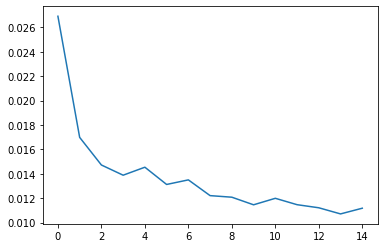

In [21]:
loss_per_epoch_model_FF = model_LSTM_petrolero_scaled.history.history['loss']
plt.plot(range(len(loss_per_epoch_model_FF)),loss_per_epoch_model_FF)

### Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_LSTM_electrico_sin_tratamiento previamente definido y entrenado

Se toman los ULTIMOS n_input elementos de los datos de train y se almacenan en un batch

In [22]:
data = demanda_petrolero_original_train_scaled

demanda_petrolero_train_batch_scaled = data[-n_input:]

demanda_petrolero_train_batch_scaled

array([[0.17129562],
       [0.18884383],
       [0.22344429],
       [0.28898387],
       [0.28898387],
       [0.19546635],
       [0.26697202],
       [0.25455845],
       [0.17767016],
       [0.34299968],
       [0.23651428],
       [0.25454386],
       [0.25681944],
       [0.23272165],
       [0.20044053],
       [0.22477171],
       [0.16481897],
       [0.11377892],
       [0.        ],
       [0.1752633 ],
       [0.29976369],
       [0.32679348],
       [0.39071389],
       [0.42546022]])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron 1, input_shape=(n_input, n_features)

In [23]:
demanda_petrolero_train_batch_scaled_reshaped = demanda_petrolero_train_batch_scaled.reshape(1,n_input, n_features)
demanda_petrolero_train_batch_scaled_reshaped

array([[[0.17129562],
        [0.18884383],
        [0.22344429],
        [0.28898387],
        [0.28898387],
        [0.19546635],
        [0.26697202],
        [0.25455845],
        [0.17767016],
        [0.34299968],
        [0.23651428],
        [0.25454386],
        [0.25681944],
        [0.23272165],
        [0.20044053],
        [0.22477171],
        [0.16481897],
        [0.11377892],
        [0.        ],
        [0.1752633 ],
        [0.29976369],
        [0.32679348],
        [0.39071389],
        [0.42546022]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [24]:
model_LSTM_petrolero_scaled.predict(demanda_petrolero_train_batch_scaled_reshaped)

1/1 [==============================] - 0s 349ms/step


array([[0.35455745]], dtype=float32)

Y se compara el valor de forecast del modelo model_sequential_and_FF con los datos de test de la demanda de gasd natural en sector eléctrico

In [26]:
demanda_petrolero_original_test_scaled[0]

array([0.34868863])

#### Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [27]:
n_input = 24
n_features = 1

In [28]:
test_predictions_model_LSTM_petrolero_scaled = []

first_eval_batch = demanda_petrolero_original_train_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_petrolero_original_test_scaled)):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_petrolero_scaled.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_petrolero_scaled.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 29ms/step


In [29]:
test_predictions_model_LSTM_petrolero_scaled

[array([0.35455745], dtype=float32),
 array([0.3531376], dtype=float32),
 array([0.35432893], dtype=float32),
 array([0.35614794], dtype=float32),
 array([0.35829532], dtype=float32),
 array([0.3605922], dtype=float32),
 array([0.36293614], dtype=float32),
 array([0.36527884], dtype=float32),
 array([0.36757696], dtype=float32),
 array([0.36982095], dtype=float32),
 array([0.37199035], dtype=float32),
 array([0.37407902], dtype=float32)]

In [30]:
test_predictions_model_LSTM_petrolero_rescaled = MinMax_scaler.inverse_transform(test_predictions_model_LSTM_petrolero_scaled)
test_predictions_model_LSTM_petrolero_rescaled

array([[1908.23331742],
       [1907.25995877],
       [1908.07665493],
       [1909.32366217],
       [1910.79577468],
       [1912.3703675 ],
       [1913.9772408 ],
       [1915.58325602],
       [1917.15870693],
       [1918.69705572],
       [1920.18426651],
       [1921.61613057]])

Se grafican los 12 meses de test vs el forecast del modelo LSTM sin la data pretratada

Text(0, 0.5, 'Demanda [MMpcd]')

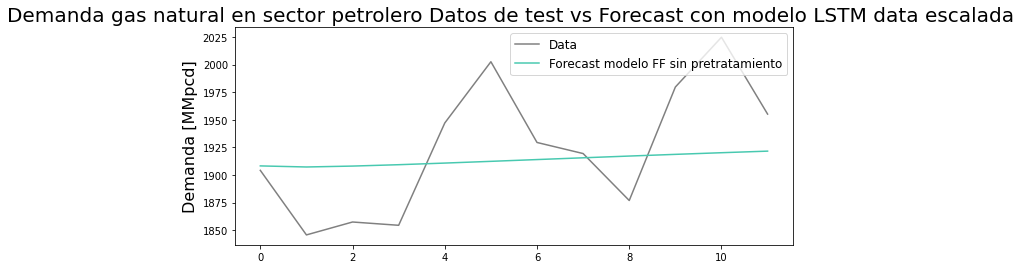

In [32]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_petrolero_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_petrolero_rescaled, color='#48C9B0')
plt.legend(('Data', 'Forecast modelo FF sin pretratamiento'), fontsize=12)

plt.title('Demanda gas natural en sector petrolero Datos de test vs Forecast con modelo LSTM data escalada ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Se calcula el error de pronóstico para los 12 meses de test con  modelo FFNN sin la data pretratada

In [33]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_LSTM_petrolero_scaled = mean_absolute_percentage_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_rescaled)
RMSE_predictions_model_LSTM_petrolero_scaled= np.sqrt(mean_squared_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_rescaled))

print('MAPE:', MAPE_predictions_model_LSTM_petrolero_scaled)
print('RMSE:', RMSE_predictions_model_LSTM_petrolero_scaled)

MAPE: 0.02393659013123187
RMSE: 55.17321178718348


## Proceso de Pretratamiento (Ajuste de valores atípicos por media aritmetica o mediana de serie) como una estrategia para mejorar los resultados de forecast de modelos LSTM Neural Networks

## Proceso de Pretratamiento Ajuste de valores atípicos por media aritmetica 

In [34]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [37]:
outlier_threshold = 1.2

import pandas as pd

def remove_replace_outliers_media(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical mean excluding outliers
    historical_mean = data[~outliers_mask].mean()

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_mean

    return data

Se genera una copia del csv_demanda_electrico_original para conservar los datos originales en un array y éstos no se vean afectados por el tratamiento de valores atípicos 

In [39]:
demanda_petrolero_original_train_para_tratamiento2 =demanda_petrolero_original_train_data.copy()
demanda_petrolero_original_train_para_tratamiento2

,Demanded_Gas
Date,
2005-01-01,2039.88
2005-02-01,2015.25
2005-03-01,1969.51
2005-04-01,2008.19
2005-05-01,2041.86
...,...
2021-05-01,1785.32
2021-06-01,1870.67
2021-07-01,1889.20


In [40]:
demanda_petrolero_train_pretratamiento_media = remove_replace_outliers_media(demanda_petrolero_original_train_para_tratamiento2['Demanded_Gas'])
demanda_petrolero_train_pretratamiento_media

Date
2005-01-01    2039.88
2005-02-01    2015.25
2005-03-01    1969.51
2005-04-01    2008.19
2005-05-01    2041.86
               ...   
2021-05-01    1785.32
2021-06-01    1870.67
2021-07-01    1889.20
2021-08-01    1933.02
2021-09-01    1956.84
Name: Demanded_Gas, Length: 201, dtype: float64

Text(0, 0.5, 'Demanda [MMpcd]')

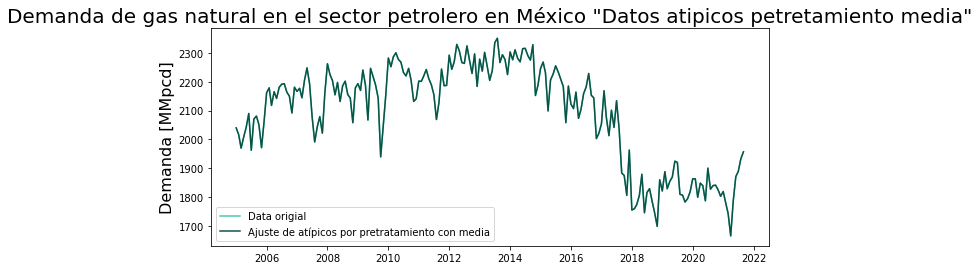

In [42]:
plt.figure(figsize=(10,4))
plt.plot(demanda_petrolero_original_train_data, color='#48C9B0')
plt.plot(demanda_petrolero_train_pretratamiento_media,color='#0B5345')
plt.legend(('Data origial', 'Ajuste de atípicos por pretratamiento con media'))
plt.title('Demanda de gas natural en el sector petrolero en México "Datos atipicos petratamiento media"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

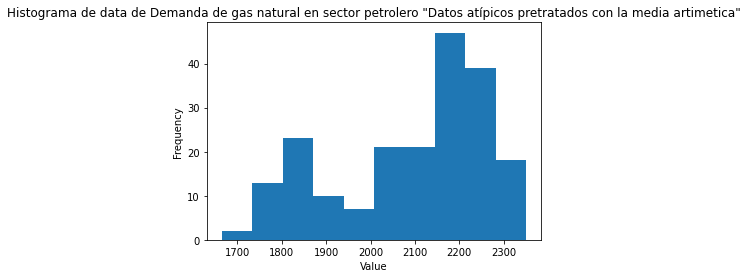

In [43]:
# Generate the histogram
plt.hist(demanda_petrolero_train_pretratamiento_media, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector petrolero "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

Se lleva a cabo una prueba de normalidad a los datos de TRAIN de Demanda en sector eléctrico para el caso de pretratamiento con la media artimetica

In [44]:
import scipy.stats as stats

# Assuming demanda_petrolero_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_petrolero_train_pretratamiento_media.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data NO sigue una distribución normal
Jarque-Bera Statistic: 20.202047251153015
p-value: 4.1037526656295675e-05


Y se observa que en este caso el tratamiento de la data si ayudó a que la data de entrenamiento pasara la prueba Jarque-Bera de normalidad 

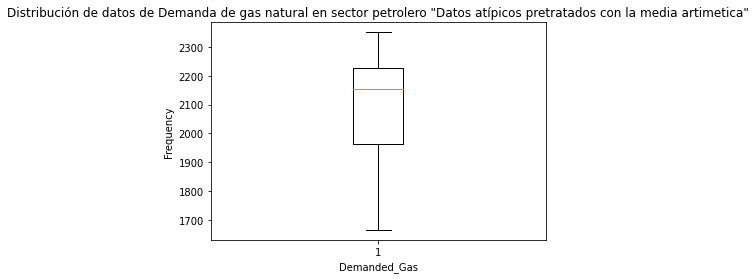

In [45]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_petrolero_train_pretratamiento_media)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector petrolero "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

#### Para la aplicación de RNN(LSTM) combiene escalar la data. Por lo que se define y entrena el MinMaxScaler (con la data de train)

In [47]:
import numpy as np

# Convert the Pandas Series to a NumPy array
demanda_petrolero_train_pretratamiento_media_array = demanda_petrolero_train_pretratamiento_media.to_numpy()

# Reshape the NumPy array
demanda_petrolero_train_pretratamiento_media_para_min_max = demanda_petrolero_train_pretratamiento_media_array.reshape(-1, 1)

In [48]:
from sklearn.preprocessing import MinMaxScaler
MinMax_scaler_petrolero_pretratamiento_media = MinMaxScaler()
MinMax_scaler_petrolero_pretratamiento_media.fit(demanda_petrolero_train_pretratamiento_media_para_min_max)

MinMaxScaler()

Se aplica la escalación la data de train

In [49]:
demanda_petrolero_train_pretratamiento_media_scaled = MinMax_scaler.transform(demanda_petrolero_train_pretratamiento_media_para_min_max)
demanda_petrolero_train_pretratamiento_media_scaled

c:\Users\Sergio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[0.54659101],
       [0.51066313],
       [0.443942  ],
       [0.50036468],
       [0.54947924],
       [0.61943869],
       [0.4333664 ],
       [0.59119818],
       [0.60631035],
       [0.56216997],
       [0.44631969],
       [0.57547335],
       [0.72423199],
       [0.74916125],
       [0.65997608],
       [0.72946874],
       [0.69559763],
       [0.75197654],
       [0.76711789],
       [0.77012282],
       [0.7268139 ],
       [0.70728185],
       [0.62177262],
       [0.7522537 ],
       [0.73110249],
       [0.74675438],
       [0.69848587],
       [0.7878169 ],
       [0.85032237],
       [0.76815357],
       [0.60384514],
       [0.47508533],
       [0.55194445],
       [0.60356799],
       [0.51989672],
       [0.7239986 ],
       [0.8710068 ],
       [0.81537182],
       [0.786577  ],
       [0.71380226],
       [0.77626397],
       [0.68012078],
       [0.75896374],
       [0.78279896],
       [0.71485253],
       [0.69704175],
       [0.57261429],
       [0.749

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc 

In [50]:
n_input = 24

data = demanda_petrolero_train_pretratamiento_media_scaled
targets = data 

demanda_petrolero_train_generator_pretratamiento_media_scaled = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)


In [51]:
demanda_petrolero_train_generator_pretratamiento_media_scaled[0]

(array([[[0.54659101],
         [0.51066313],
         [0.443942  ],
         [0.50036468],
         [0.54947924],
         [0.61943869],
         [0.4333664 ],
         [0.59119818],
         [0.60631035],
         [0.56216997],
         [0.44631969],
         [0.57547335],
         [0.72423199],
         [0.74916125],
         [0.65997608],
         [0.72946874],
         [0.69559763],
         [0.75197654],
         [0.76711789],
         [0.77012282],
         [0.7268139 ],
         [0.70728185],
         [0.62177262],
         [0.7522537 ]]]),
 array([[0.73110249]]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [52]:
print("Total number of samples in the original training data = ", len(demanda_petrolero_train_pretratamiento_media)) 
print("Total number of samples in the demanda_petrolero_scaled_train_generator = ", len(demanda_petrolero_train_generator_pretratamiento_media_scaled))

Total number of samples in the original training data =  201
Total number of samples in the demanda_petrolero_scaled_train_generator =  177


Se define la red neuronal sequencial LSTM con capas densas y funcion de activación tipo RELU.  

In [53]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [54]:
n_input = 24
n_features = 1

# define model
model_LSTM_petrolero_pretratamiento_media_scaled = Sequential()
model_LSTM_petrolero_pretratamiento_media_scaled.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_petrolero_pretratamiento_media_scaled.add(Dense(1))
model_LSTM_petrolero_pretratamiento_media_scaled.compile(optimizer='adam', loss='mse')

In [55]:
model_LSTM_petrolero_pretratamiento_media_scaled.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenamos el modelo  Feed Forward Sequential Neural Network con el demanda_electrico_scaled_train_generator.
Es decir se está entrenando al modelo para que con los valores de entrenamiento "ajuste sus pesos y bias" de manera que se esté tomando n_inputs como "variables predictoas" y el +1 valor después de los n_input como variable dependiente Y. y asñi se va recorriendo el n_input. De manera que se tienen n_total_elementos_en_train - n_input valores de entrada de tamaño n_input y n_total_elementos_en_train - n_input valores de salida de tamaño 1 (Representando la Y calculada)  

In [56]:
model_LSTM_petrolero_pretratamiento_media_scaled.fit(demanda_petrolero_train_generator_pretratamiento_media_scaled, epochs=25)

Epoch 1/25


177/177 [==============================] - 3s 9ms/step - loss: 0.0317
Epoch 2/25
177/177 [==============================] - 1s 7ms/step - loss: 0.0160
Epoch 3/25
177/177 [==============================] - 1s 8ms/step - loss: 0.0153
Epoch 4/25
177/177 [==============================] - 1s 8ms/step - loss: 0.0151
Epoch 5/25
177/177 [==============================] - 2s 9ms/step - loss: 0.0129
Epoch 6/25
177/177 [==============================] - 1s 8ms/step - loss: 0.0121
Epoch 7/25
177/177 [==============================] - 1s 8ms/step - loss: 0.0134
Epoch 8/25
177/177 [==============================] - 1s 8ms/step - loss: 0.0135
Epoch 9/25
177/177 [==============================] - 1s 7ms/step - loss: 0.0124
Epoch 10/25
177/177 [==============================] - 1s 8ms/step - loss: 0.0125
Epoch 11/25
177/177 [==============================] - 1s 7ms/step - loss: 0.0119
Epoch 12/25
177/177 [==============================] - 1s 7ms/step - loss: 0.0113
Epoch 13/25
177/177 [===============

Se grafica la perdida por epoch 

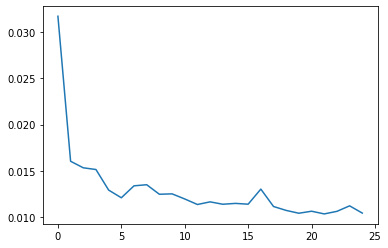

In [57]:
loss_per_epoch = model_LSTM_petrolero_pretratamiento_media_scaled.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los **ULTIMOS** n_input elementos de los **datos de train** y se almacenan en un batch

In [58]:
demanda_petrolero_train_batch_pretratamiento_media_scaled = demanda_petrolero_train_pretratamiento_media_scaled[-n_input:]


demanda_petrolero_train_batch_pretratamiento_media_scaled

array([[0.17129562],
       [0.18884383],
       [0.22344429],
       [0.28898387],
       [0.28898387],
       [0.19546635],
       [0.26697202],
       [0.25455845],
       [0.17767016],
       [0.34299968],
       [0.23651428],
       [0.25454386],
       [0.25681944],
       [0.23272165],
       [0.20044053],
       [0.22477171],
       [0.16481897],
       [0.11377892],
       [0.        ],
       [0.1752633 ],
       [0.29976369],
       [0.32679348],
       [0.39071389],
       [0.42546022]])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron  1, input_shape=(n_input, n_features)

In [59]:
demanda_petrolero_train_batch_pretratamiento_media_scaled_reshaped = demanda_petrolero_train_batch_pretratamiento_media_scaled.reshape(1,n_input, n_features)
demanda_petrolero_train_batch_pretratamiento_media_scaled_reshaped

array([[[0.17129562],
        [0.18884383],
        [0.22344429],
        [0.28898387],
        [0.28898387],
        [0.19546635],
        [0.26697202],
        [0.25455845],
        [0.17767016],
        [0.34299968],
        [0.23651428],
        [0.25454386],
        [0.25681944],
        [0.23272165],
        [0.20044053],
        [0.22477171],
        [0.16481897],
        [0.11377892],
        [0.        ],
        [0.1752633 ],
        [0.29976369],
        [0.32679348],
        [0.39071389],
        [0.42546022]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [60]:
model_LSTM_petrolero_pretratamiento_media_scaled.predict(demanda_petrolero_train_batch_pretratamiento_media_scaled_reshaped)

1/1 [==============================] - 0s 433ms/step


array([[0.34509328]], dtype=float32)

Y se compara el valor de forecast del modelo LSTM + pretratamiento media + normalizacion con los datos de test de la demanda de gas natural en sector eléctrico

In [61]:
demanda_petrolero_original_test_scaled[0]

array([0.34868863])

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [62]:
n_input = 24
n_features = 1

In [63]:
test_predictions_model_LSTM_petrolero_pretratamiento_media_scaled  = []

first_eval_batch = demanda_petrolero_train_pretratamiento_media_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_petrolero_original_test_scaled)):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_petrolero_pretratamiento_media_scaled.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_petrolero_pretratamiento_media_scaled.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 21ms/step


In [64]:
test_predictions_model_LSTM_petrolero_pretratamiento_media_scaled 

[array([0.34509328], dtype=float32),
 array([0.3321401], dtype=float32),
 array([0.32362828], dtype=float32),
 array([0.31640223], dtype=float32),
 array([0.30995956], dtype=float32),
 array([0.30400106], dtype=float32),
 array([0.29837084], dtype=float32),
 array([0.29297632], dtype=float32),
 array([0.28776035], dtype=float32),
 array([0.2827173], dtype=float32),
 array([0.27778414], dtype=float32),
 array([0.27296412], dtype=float32)]

In [65]:
test_predictions_model_LSTM_petrolero_pretratamiento_media_rescaled = MinMax_scaler.inverse_transform(test_predictions_model_LSTM_petrolero_pretratamiento_media_scaled)
test_predictions_model_LSTM_petrolero_pretratamiento_media_rescaled

array([[1901.74524722],
       [1892.86531598],
       [1887.03012873],
       [1882.07638248],
       [1877.6596772 ],
       [1873.5748888 ],
       [1869.7151444 ],
       [1866.01698627],
       [1862.44122837],
       [1858.9840093 ],
       [1855.60213859],
       [1852.29782276]])

Separamos la Demanda de gas natural ORIGINAL en el sector eléctrico en data de train y test

In [66]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
demanda_petrolero_original_train_data = csv_demanda_petrolero_original[:-num_test_points]
demanda_petrolero_original_test_data = csv_demanda_petrolero_original[-num_test_points:]

demanda_petrolero_original_train_data

,Demanded_Gas
Date,
2005-01-01,2039.88
2005-02-01,2015.25
2005-03-01,1969.51
2005-04-01,2008.19
2005-05-01,2041.86
...,...
2021-05-01,1785.32
2021-06-01,1870.67
2021-07-01,1889.20


In [67]:
demanda_petrolero_original_test_data['Demanded_Gas'].values

array([1904.21, 1845.7 , 1857.4 , 1854.42, 1947.12, 2002.63, 1929.47,
       1919.43, 1876.88, 1979.7 , 2024.82, 1955.19])

Text(0, 0.5, 'Demanda [MMpcd]')

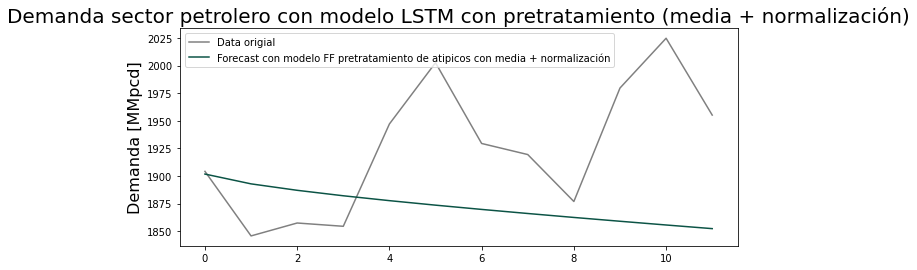

In [69]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_petrolero_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_petrolero_pretratamiento_media_rescaled , color='#0B5345')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo FF pretratamiento de atipicos con media + normalización'))

plt.title('Demanda sector petrolero con modelo LSTM con pretratamiento (media + normalización)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [70]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_LSTM_petrolero_pretratamiento_media_scaled = mean_absolute_percentage_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_pretratamiento_media_rescaled)
RMSE_test_predictions_model_LSTM_petrolero_pretratamiento_media_scaled = np.sqrt(mean_squared_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_pretratamiento_media_rescaled))

print('MAPE:', MAPE_test_predictions_model_LSTM_petrolero_pretratamiento_media_scaled)
print('RMSE:', RMSE_test_predictions_model_LSTM_petrolero_pretratamiento_media_scaled)

MAPE: 0.03512457456861123
RMSE: 84.54748484571842


Se muestra la comparación del forecast de demanda electrico con modelo FFNN entre train data sin pretratamiento y con pretratamiento de atípicos con la media

Text(0, 0.5, 'Demanda [MMpcd]')

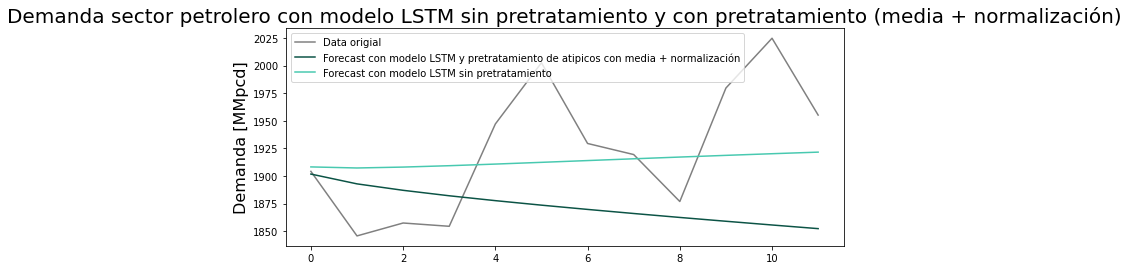

In [72]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_petrolero_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_petrolero_pretratamiento_media_rescaled , color='#0B5345')
plt.plot(test_predictions_model_LSTM_petrolero_rescaled, color='#48C9B0')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM y pretratamiento de atipicos con media + normalización', 'Forecast con modelo LSTM sin pretratamiento'))

plt.title('Demanda sector petrolero con modelo LSTM sin pretratamiento y con pretratamiento (media + normalización)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

## Proceso de Pretratamiento Ajuste de valores atípicos por mediana 

In [73]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [74]:
outlier_threshold = 1.2

import pandas as pd

def remove_replace_outliers_mediana(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical meadian excluding outliers
    historical_median = np.median(data[~outliers_mask])

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_median

    return data

In [75]:
demanda_petrolero_original_train_para_tratamiento2 =demanda_petrolero_original_train_data.copy()
demanda_petrolero_original_train_para_tratamiento2

,Demanded_Gas
Date,
2005-01-01,2039.88
2005-02-01,2015.25
2005-03-01,1969.51
2005-04-01,2008.19
2005-05-01,2041.86
...,...
2021-05-01,1785.32
2021-06-01,1870.67
2021-07-01,1889.20


In [76]:
demanda_petrolero_train_pretratamiento_mediana = remove_replace_outliers_mediana(demanda_petrolero_original_train_para_tratamiento2['Demanded_Gas'])
demanda_petrolero_train_pretratamiento_mediana

Date
2005-01-01    2039.88
2005-02-01    2015.25
2005-03-01    1969.51
2005-04-01    2008.19
2005-05-01    2041.86
               ...   
2021-05-01    1785.32
2021-06-01    1870.67
2021-07-01    1889.20
2021-08-01    1933.02
2021-09-01    1956.84
Name: Demanded_Gas, Length: 201, dtype: float64

Text(0, 0.5, 'Demanda [MMpcd]')

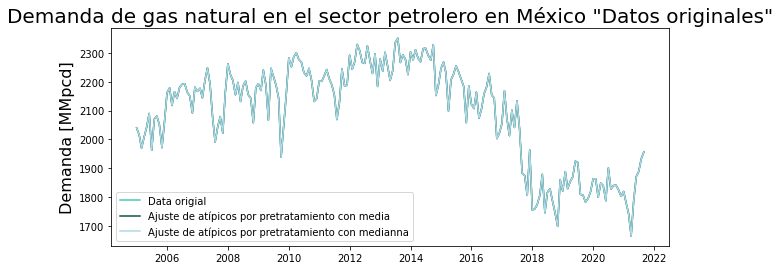

In [77]:
plt.figure(figsize=(10,4))
plt.plot(demanda_petrolero_original_train_data, color='#48C9B0')
plt.plot(demanda_petrolero_train_pretratamiento_media,color='#0B5345')
plt.plot(demanda_petrolero_train_pretratamiento_mediana, color= 'lightblue')
plt.legend(('Data origial', 'Ajuste de atípicos por pretratamiento con media', 'Ajuste de atípicos por pretratamiento con medianna'))
plt.title('Demanda de gas natural en el sector petrolero en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data con pretratamiento de mediana de Demanda en sector eléctrico en sus componentes de Tendencia, Estacionalidad y Residual

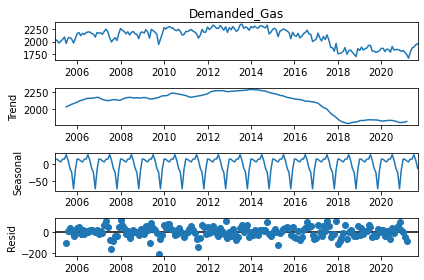

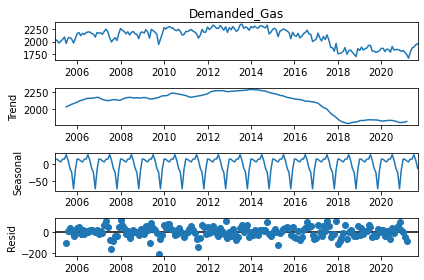

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose

demanda_petrolero_train_pretratamiento_mediana_seasonal_decomposition = seasonal_decompose(demanda_petrolero_train_pretratamiento_mediana)
demanda_petrolero_train_pretratamiento_mediana_seasonal_decomposition.plot()


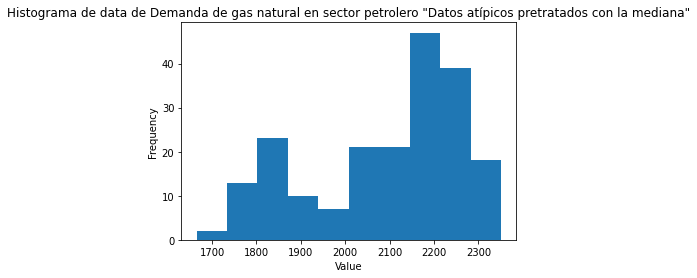

In [79]:
# Generate the histogram
plt.hist(demanda_petrolero_train_pretratamiento_mediana, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector petrolero "Datos atípicos pretratados con la mediana"')

# Display the plot
plt.show()

In [80]:
import scipy.stats as stats

# Assuming demanda_petrolero_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_petrolero_train_pretratamiento_mediana.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data NO sigue una distribución normal
Jarque-Bera Statistic: 20.202047251153015
p-value: 4.1037526656295675e-05


Para la aplicación de RNN(LSTM) combiene escalar la data. Por lo que se define y entrena el MinMaxScaler (con la data de train)

In [81]:
import numpy as np

# Convert the Pandas Series to a NumPy array
demanda_petrolero_train_pretratamiento_mediana_array = demanda_petrolero_train_pretratamiento_mediana.to_numpy()

# Reshape the NumPy array
demanda_petrolero_train_pretratamiento_mediana_para_min_max = demanda_petrolero_train_pretratamiento_mediana_array.reshape(-1, 1)

In [82]:
from sklearn.preprocessing import MinMaxScaler
MinMax_scaler_petrolero_pretratamiento_mediana = MinMaxScaler()
MinMax_scaler_petrolero_pretratamiento_mediana.fit(demanda_petrolero_train_pretratamiento_mediana_para_min_max)

MinMaxScaler()

Se aplica la escalación la data de train

In [83]:
demanda_petrolero_train_pretratamiento_mediana_scaled = MinMax_scaler.transform(demanda_petrolero_train_pretratamiento_mediana_para_min_max)
demanda_petrolero_train_pretratamiento_mediana_scaled

c:\Users\Sergio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[0.54659101],
       [0.51066313],
       [0.443942  ],
       [0.50036468],
       [0.54947924],
       [0.61943869],
       [0.4333664 ],
       [0.59119818],
       [0.60631035],
       [0.56216997],
       [0.44631969],
       [0.57547335],
       [0.72423199],
       [0.74916125],
       [0.65997608],
       [0.72946874],
       [0.69559763],
       [0.75197654],
       [0.76711789],
       [0.77012282],
       [0.7268139 ],
       [0.70728185],
       [0.62177262],
       [0.7522537 ],
       [0.73110249],
       [0.74675438],
       [0.69848587],
       [0.7878169 ],
       [0.85032237],
       [0.76815357],
       [0.60384514],
       [0.47508533],
       [0.55194445],
       [0.60356799],
       [0.51989672],
       [0.7239986 ],
       [0.8710068 ],
       [0.81537182],
       [0.786577  ],
       [0.71380226],
       [0.77626397],
       [0.68012078],
       [0.75896374],
       [0.78279896],
       [0.71485253],
       [0.69704175],
       [0.57261429],
       [0.749

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [84]:
n_input = 24

data = demanda_petrolero_train_pretratamiento_mediana_scaled
targets = data 

demanda_petrolero_train_generator_pretratamiento_mediana_scaled = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)
demanda_petrolero_train_generator_pretratamiento_mediana_scaled[0]

(array([[[0.54659101],
         [0.51066313],
         [0.443942  ],
         [0.50036468],
         [0.54947924],
         [0.61943869],
         [0.4333664 ],
         [0.59119818],
         [0.60631035],
         [0.56216997],
         [0.44631969],
         [0.57547335],
         [0.72423199],
         [0.74916125],
         [0.65997608],
         [0.72946874],
         [0.69559763],
         [0.75197654],
         [0.76711789],
         [0.77012282],
         [0.7268139 ],
         [0.70728185],
         [0.62177262],
         [0.7522537 ]]]),
 array([[0.73110249]]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [85]:
print("Total number of samples in the original training data = ", len(demanda_petrolero_train_pretratamiento_mediana)) 
print("Total number of samples in the demanda_petrolero_scaled_train_generator = ", len(demanda_petrolero_train_generator_pretratamiento_mediana_scaled))

Total number of samples in the original training data =  201
Total number of samples in the demanda_petrolero_scaled_train_generator =  177


Se define la red neuronal sequencial FFNN con capas densas y funcion de activación tipo RELU para el caso de la demanda en sector electrico con pretratamiento de mediana 

In [86]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [87]:
n_input = 24
n_features = 1

# define model
model_LSTM_petrolero_pretrataminto_mediana_scaled = Sequential()

model_LSTM_petrolero_pretrataminto_mediana_scaled.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_petrolero_pretrataminto_mediana_scaled.add(Dense(1))
model_LSTM_petrolero_pretrataminto_mediana_scaled.compile(optimizer='adam', loss='mse')

model_LSTM_petrolero_pretrataminto_mediana_scaled.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Se entrena el modelo 

In [88]:
model_LSTM_petrolero_pretrataminto_mediana_scaled.fit(demanda_petrolero_train_generator_pretratamiento_mediana_scaled, epochs=25)

Epoch 1/25
177/177 [==============================] - 3s 7ms/step - loss: 0.0618
Epoch 2/25
177/177 [==============================] - 1s 8ms/step - loss: 0.0176
Epoch 3/25
177/177 [==============================] - 2s 8ms/step - loss: 0.0159
Epoch 4/25
177/177 [==============================] - 1s 7ms/step - loss: 0.0155
Epoch 5/25
177/177 [==============================] - 1s 7ms/step - loss: 0.0140
Epoch 6/25
177/177 [==============================] - 1s 8ms/step - loss: 0.0148
Epoch 7/25
177/177 [==============================] - 1s 7ms/step - loss: 0.0140
Epoch 8/25
177/177 [==============================] - 1s 8ms/step - loss: 0.0140
Epoch 9/25
177/177 [==============================] - 1s 7ms/step - loss: 0.0133
Epoch 10/25
177/177 [==============================] - 1s 7ms/step - loss: 0.0129
Epoch 11/25
177/177 [==============================] - 1s 8ms/step - loss: 0.0122
Epoch 12/25
177/177 [==============================] - 1s 8ms/step - loss: 0.0115
Epoch 13/25
177/177 [====

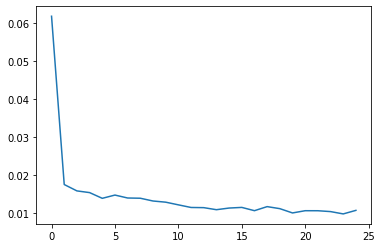

In [89]:
loss_per_epoch = model_LSTM_petrolero_pretrataminto_mediana_scaled.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los ULTIMOS n_input elementos de los datos de train y se almacenan en un batch

In [90]:
demanda_petrolero_train_pretratamiento_mediana_scaled

array([[0.54659101],
       [0.51066313],
       [0.443942  ],
       [0.50036468],
       [0.54947924],
       [0.61943869],
       [0.4333664 ],
       [0.59119818],
       [0.60631035],
       [0.56216997],
       [0.44631969],
       [0.57547335],
       [0.72423199],
       [0.74916125],
       [0.65997608],
       [0.72946874],
       [0.69559763],
       [0.75197654],
       [0.76711789],
       [0.77012282],
       [0.7268139 ],
       [0.70728185],
       [0.62177262],
       [0.7522537 ],
       [0.73110249],
       [0.74675438],
       [0.69848587],
       [0.7878169 ],
       [0.85032237],
       [0.76815357],
       [0.60384514],
       [0.47508533],
       [0.55194445],
       [0.60356799],
       [0.51989672],
       [0.7239986 ],
       [0.8710068 ],
       [0.81537182],
       [0.786577  ],
       [0.71380226],
       [0.77626397],
       [0.68012078],
       [0.75896374],
       [0.78279896],
       [0.71485253],
       [0.69704175],
       [0.57261429],
       [0.749

In [91]:
demanda_petrolero_train_batch_pretratamiento_mediana_scaled = demanda_petrolero_train_pretratamiento_mediana_scaled[-n_input:]


demanda_petrolero_train_batch_pretratamiento_mediana_scaled

array([[0.17129562],
       [0.18884383],
       [0.22344429],
       [0.28898387],
       [0.28898387],
       [0.19546635],
       [0.26697202],
       [0.25455845],
       [0.17767016],
       [0.34299968],
       [0.23651428],
       [0.25454386],
       [0.25681944],
       [0.23272165],
       [0.20044053],
       [0.22477171],
       [0.16481897],
       [0.11377892],
       [0.        ],
       [0.1752633 ],
       [0.29976369],
       [0.32679348],
       [0.39071389],
       [0.42546022]])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron 1, input_shape=(n_input, n_features)

In [92]:
demanda_petrolero_train_batch_pretratamiento_mediana_scaled_reshaped = demanda_petrolero_train_batch_pretratamiento_mediana_scaled.reshape(1,n_input, n_features)
demanda_petrolero_train_batch_pretratamiento_mediana_scaled_reshaped

array([[[0.17129562],
        [0.18884383],
        [0.22344429],
        [0.28898387],
        [0.28898387],
        [0.19546635],
        [0.26697202],
        [0.25455845],
        [0.17767016],
        [0.34299968],
        [0.23651428],
        [0.25454386],
        [0.25681944],
        [0.23272165],
        [0.20044053],
        [0.22477171],
        [0.16481897],
        [0.11377892],
        [0.        ],
        [0.1752633 ],
        [0.29976369],
        [0.32679348],
        [0.39071389],
        [0.42546022]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [93]:
model_LSTM_petrolero_pretrataminto_mediana_scaled.predict(demanda_petrolero_train_batch_pretratamiento_mediana_scaled_reshaped)

1/1 [==============================] - 0s 300ms/step


array([[0.36338595]], dtype=float32)

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [94]:
n_input = 24
n_features = 1

In [95]:
test_predictions_model_LSTM_petrolero_pretratamiento_mediana_scaled  = []

first_eval_batch = demanda_petrolero_train_pretratamiento_mediana_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_petrolero_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_petrolero_pretrataminto_mediana_scaled.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_petrolero_pretratamiento_mediana_scaled.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1) 

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 22ms/step


In [96]:
test_predictions_model_LSTM_petrolero_pretratamiento_mediana_scaled

[array([0.36338595], dtype=float32),
 array([0.35082737], dtype=float32),
 array([0.34117976], dtype=float32),
 array([0.3314011], dtype=float32),
 array([0.321531], dtype=float32),
 array([0.31163055], dtype=float32),
 array([0.30176637], dtype=float32),
 array([0.29192346], dtype=float32),
 array([0.28214714], dtype=float32),
 array([0.27248257], dtype=float32),
 array([0.26284382], dtype=float32),
 array([0.25323415], dtype=float32)]

In [97]:
test_predictions_model_LSTM_petrolero_pretratamiento_mediana_rescaled = MinMax_scaler.inverse_transform(test_predictions_model_LSTM_petrolero_pretratamiento_mediana_scaled)
test_predictions_model_LSTM_petrolero_pretratamiento_mediana_rescaled

array([[1914.28560112],
       [1905.67619257],
       [1899.06237151],
       [1892.35871674],
       [1885.5923602 ],
       [1878.80520522],
       [1872.04291439],
       [1865.29521106],
       [1858.59314988],
       [1851.96770377],
       [1845.35995063],
       [1838.77213784]])

Text(0, 0.5, 'Demanda [MMpcd]')

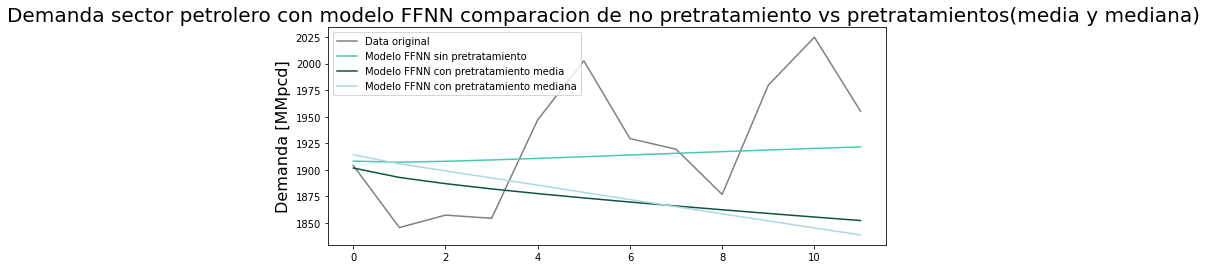

In [99]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_petrolero_original_test_data['Demanded_Gas'].values, color='gray')
plt.plot(test_predictions_model_LSTM_petrolero_rescaled, color='#48C9B0')
plt.plot(test_predictions_model_LSTM_petrolero_pretratamiento_media_rescaled , color='#0B5345')
plt.plot(test_predictions_model_LSTM_petrolero_pretratamiento_mediana_rescaled , color='lightblue')
plt.legend(('Data original', 'Modelo FFNN sin pretratamiento', 'Modelo FFNN con pretratamiento media', 'Modelo FFNN con pretratamiento mediana'), fontsize=10)

plt.title('Demanda sector petrolero con modelo FFNN comparacion de no pretratamiento vs pretratamientos(media y mediana) ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [100]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_LSTM_petrolero_pretratamiento_mediana = mean_absolute_percentage_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_pretratamiento_mediana_rescaled)
RMSE_test_predictions_model_LSTM_petrolero_pretratamiento_mediana = np.sqrt(mean_squared_error(demanda_petrolero_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_petrolero_pretratamiento_mediana_rescaled))

print('MAPE:', MAPE_test_predictions_model_LSTM_petrolero_pretratamiento_mediana)
print('RMSE:', RMSE_test_predictions_model_LSTM_petrolero_pretratamiento_mediana)

MAPE: 0.03787581764598968
RMSE: 88.80193924995623
